# Preparacion del entorno

Librerias

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import ipynb.fs     #Para importar desde ipynb
import matplotlib.pyplot as plt

Num GPUs Available:  1


# Preparacion de los datos

In [2]:
from utilities import *

(60000, 28, 28, 1)


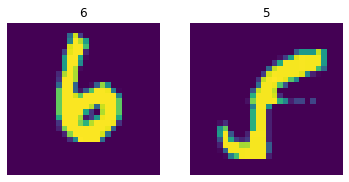

(10000, 28, 28, 1)


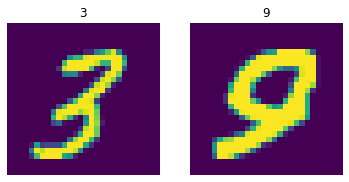

In [3]:
X_train = unpickle("Input\MNIST-train")
X_test = unpickle("Input\MNIST-test")
tryDataset(X_train)
tryDataset(X_test)

# Entrenamiento

In [4]:
from AutoencoderLib import *

## Persistencia

In [5]:
_raiz = "Resultados/MNISTpruebasAAE"
_nombre = "MNISTpAAE"

In [6]:
mkfolders(_raiz, True)

Carpeta Resultados/MNISTpruebasAAE ya existe


## Funciones de muestreo

In [7]:
def plotlatent2D(encoder, dataset, ruta=_raiz, nombre=_nombre):
    ruta+="/Output/Latente"
    mkfolders(ruta)
    points = encoder.predict(dataset["data"])

    x = np.array(list(x for (x,_) in points))
    y = np.array(list(y for (_,y) in points))
    colors = dataset["labels"]

    plt.scatter(x, y, c=colors, cmap='hsv')

    mixture = compute_mixture(dataset, encoder, points)
    colors, x, y = [], [], []
    for key in mixture.keys():
        colors.append(key)
        x.append(mixture[key]["mu"][0])
        y.append(mixture[key]["mu"][1])

    plt.scatter(x, y, c=colors, cmap='hsv', marker="*", edgecolors="black")

    plt.colorbar()
    fig = plt.gcf()
    plt.show()
    fig.savefig(ruta+"\\"+nombre+"_space.jpg")
    plt.close()

In [8]:
def compute_mixture(dataset, encoder, points = None, override=False, ruta="Data/", nombre="mixtureData", dataset_name=""):
    exists=os.path.isfile(ruta+"/"+nombre)
    
    if exists and not override:
        return load_mixture(ruta=ruta, nombre=nombre)
    
    if points is None:
        points = encoder.predict(dataset["data"])
        
    mixture = {}
    for i, label in enumerate(dataset["labels"]):
        if label in mixture.keys():
            mixture[label].append(points[i])
        else:
            mixture[label]= [points[i]]
    for index in mixture.keys():
        cluster = mixture[index]
        mixture[index] = {"mu":[], "sigma":[]}
        mixture[index]["mu"]=np.median(cluster, axis=0)
        mixture[index]["sigma"]=np.std(cluster, axis=0)
        
    if not exists or override:    
        print("Guardando datos de la mixtura para "+dataset_name+"-"+nombre)
        mkfolders(ruta=ruta)
        saveDataset(dataset=mixture, input_path=ruta, dataset_name=dataset_name, name=nombre)
        
    return mixture

In [9]:
def load_mixture(ruta="Data/", nombre="mixtureData", dataset_name="", expansion=1, **kwargs):
    mixture = unpickle(ruta+dataset_name+"-"+nombre)
    for v in mixture.values():
        v["mu"] = np.multiply(v["mu"], expansion)
    return mixture

## Generacion de ejemplos (positivos y negativos)

In [10]:
def generateRandomVectors(dim_latente, batch_size, nclases):
    vectors = []
    labels = np.zeros((batch_size, nclases))
    
    for label in labels:
        l = np.random.randint(0, nclases)
        label[l] = 1
        mean = [10*np.cos((l*2*np.pi)/10), 10*np.sin((l*2*np.pi)/10)]
        v1 = [np.cos((l*2*np.pi)/10), np.sin((l*2*np.pi)/10)]
        v2 = [-np.sin((l*2*np.pi)/10), np.cos((l*2*np.pi)/10)]
        a1 = 8
        a2 = .4
        M =np.vstack((v1,v2)).T
        S = np.array([[a1, 0], [0, a2]])
        cov = np.dot(np.dot(M, S), np.linalg.inv(M))
        #cov = cov*cov.T
        vec = np.random.multivariate_normal(mean=mean, cov=cov,
                                            size=1)
        vectors.append(vec)
    return (np.array(vectors).reshape(-1, 2), labels)

In [11]:
def genFromMixture(dim_latente, batch_size, nclases, mixture):
    samples = []
    clases = np.random.randint(0, nclases, batch_size)
    clases1hot= onehotify(clases, nclases)
    for clase in clases: 
        s = np.random.normal(loc = mixture[clase]["mu"], scale=mixture[clase]["sigma"], size=dim_latente)
        samples.append(s)
    return np.array(samples), clases1hot

## Funcion de entrenamiento

In [12]:
from AutoencoderLib import (
    fit_AAE_twoPhased as fit_AAE
    )


## Entrenamiento en grid

Tamaño de la capa latente:

In [13]:
dim_latente_cand = [2]

Tamaño de las imagenes:

In [14]:
img_shape = X_train["data"][0].shape

Parametros:

In [15]:
encoders = [(build_dense_encoder, "dense_enc"), (build_transf_encoder,"transf_enc"), (build_conv_encoder,"conv_enc")]

decoders = [(build_dense_decoder,"dense_dec"), (build_conv_decoder,"conv_dec")]

discriminators = [(build_discriminator ,"default_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
                    (build_class_discriminator ,"class_disc",{"clases":10}, {"truth":genFromMixture, "truth_kwargs":{"nclases":10, "mixture":None}, "falsehood":fake_class_sampler})]


ae_losses = [(losses.mean_squared_error, "ae_MSE_loss")]
disc_losses =[(losses.binary_crossentropy, "disc_binXentropy_loss")]

In [16]:
#dim_latente_cand = [64]                         # para que las pruebas no tarden 2 horas
#dim_latente_cand = [64, 256, 1024]              # para que las pruebas no tarden 7 horas
#decoders = [(build_dense_decoder,"dense_dec")]  # para que las pruebas no tarden 2 horas

In [17]:
epochs = 12

In [22]:
def tryModel(
    model_name="MODEL", 
    enc= (build_dense_encoder, "dense_enc"), 
    dec = (build_dense_decoder,"dense_dec"),
    ae_loss = (losses.mean_squared_error, "ae_MSE_loss"),
    disc = (build_discriminator ,"default_disc", {}, {"truth":true_sampler, "truth_kwargs":{}, "falsehood":fake_sampler}),
    disc_loss = (losses.binary_crossentropy, "disc_binXentropy_loss"),
    dim_latente = 2,
    mixture_data={"override":False, "nombre":"2dcluster"},
    save=False
    ):
    # Carpeta donde almacenar los resultados
    ruta = _raiz+"\\"+model_name+"\\"+ae_loss[1]+"\\"+disc[1]+"\\"+disc_loss[1]+"\\"+str(dim_latente)
    # Si existen los modelos solo mostrar resultados guardados sin entrenar
    if os.path.isfile(ruta+"/Modelos\\decoder.h5") or os.path.isfile(ruta+"/Modelos\\autoencoder.h5"):
        print(ruta+" ya ha sido entrenada")
        show_prevResults(ruta, epochs=epochs)
        return
    # Crear carpeta
    mkfolders(ruta, True)
    # Intentar cargar datos de mixtura si se trata de un dsicriminador con informacion de clases
    if "clases" in disc[2].keys():
        mixture = load_mixture(ruta="Data/", dataset_name="MNIST", expansion=10, **mixture_data)
        disc[3]["truth_kwargs"].update({"mixture":mixture})
    # Creacion de los modelos
    ck = {"ae_loss": ae_loss[0], "disc_loss":disc_loss[0]}
    aae = assemble_AAE(dim_latente, img_shape, enc_model = enc[0], dec_model = dec[0], disc_model = disc[0], 
                    compilation_kwargs=ck, disc_kwargs=disc[2])
    # Entrenamiento
    fit_settings = {"dim_latente":dim_latente, "aae":aae, "epochs":epochs, "ruta" : ruta}
    fit_settings.update(disc[3])
    history = fit_AAE(dataset=X_train, **fit_settings)
    (encoder, decoder, _, autoencoder) = aae
    # Obtenemos informacion del numero de clases para mostrar resultados, si no hay se intenta generar una mixtura para mas tarde
    clases=0
    if "clases" in disc[2].keys():
        clases=disc[2]["clases"]
    else:
        compute_mixture(X_train, encoder, ruta="Data/", dataset_name="MNIST", **mixture_data)
    #Resultados
    print("Historia del entrenamiento:")
    plot_history(history, ruta=ruta, title=ruta)
    print("Imagenes regeneradas desde el set de entrenamiento (arriba originales):")
    sample_imgs(X_train, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TRAINSET")
    print("Imagenes regeneradas desde imagenes nunca vistas por la red (arriba originales):")
    sample_imgs(X_test, autoencoder, epoch=epochs, nclases=clases, show=True, ruta=ruta, title=ruta+" regeneration", nombre="TESTSET")
    print("Representacion del espacio latente 2D:")
    plotlatent2D(encoder, X_test, ruta=ruta, nombre="TESTSET")
    # Guardado de modelos
    if save:
        mkfolders(ruta+"/Modelos")
        decoder.save(ruta+"/Modelos\\decoder.h5")
        autoencoder.save(ruta+"/Modelos\\autoencoder.h5")


### Entrenamiento de AAE Denso

No piramide vs piramide

In [ ]:
enc = (build_dense_encoder, "dense_enc")
dec = (build_dense_decoder,"dense_dec")
model_name = "DENSE"
tryModel(enc=enc, dec=dec, model_name=model_name, mixture_data={"override":True, "nombre":"2dcluster"})

In [ ]:
enc = (build_dense_encoder_P, "dense_enc")
dec = (build_dense_decoder_P,"dense_dec")
model_name = "DENSE_P"
tryModel(enc=enc, dec=dec, model_name=model_name, mixture_data={"override":False, "nombre":"2dcluster"})

Compute Mixture vs Generate random vectors

In [ ]:
enc = (build_dense_encoder, "dense_enc")
dec = (build_dense_decoder,"dense_dec")

In [ ]:
disc=(build_class_discriminator ,"class_disc",{"clases":10}, {"truth":genFromMixture, "truth_kwargs":{"nclases":10, "mixture":None}, "falsehood":fake_class_sampler})
model_name = "DENSE_MIX"
tryModel(enc=enc, dec=dec, disc=disc, model_name=model_name, mixture_data={"override":False, "nombre":"2dcluster"})

In [ ]:
disc=(build_class_discriminator ,"class_disc",{"clases":10}, {"truth":generateRandomVectors, "truth_kwargs":{"nclases":10}, "falsehood":fake_class_sampler})
model_name = "DENSE_VEC"
tryModel(enc=enc, dec=dec, disc=disc, model_name=model_name)

### Entrenamiento AAE Convolucional

In [ ]:
enc = (build_conv_encoder, "conv_enc")
dec = (build_conv_decoder,"conv_dec")
model_name = "CONVOLUTIONAL"

tryModel(enc=enc, dec=dec, model_name=model_name, mixture_data={"override":False, "nombre":"2dcluster_Convolucional"})